<a href="https://colab.research.google.com/github/Nancy-Shi/Complex_Networks/blob/main/062823_hyperedge_model_info_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
def deg_seq_hyperedge_seq(n_nodes, gamma, kmin, n_groups):
    """
    input: number of nodes, power-law degree distribution exponent,
           minimum degree, number of hyperedge groups
    method: create a degree sequence, sum all degrees
            then distribute the degrees randomly among
            the number of hyperedges given, the hyperedges list
            should contain how many items each hyperedge connects
    output: a degree sequence,
            a hyperedge sequence which is how many nodes each hyperedge group contains.
    """

    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n_nodes)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(((gamma-1)/(gamma-2) * n_nodes )** (1/gamma))  # max degree
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n_nodes:
        degrees = degrees[:n_nodes]
    else:
        degrees = np.concatenate((degrees, np.full(n_nodes - len(degrees), kmin)))

    # Sum all degrees
    total_degrees = np.sum(degrees)

    # Calculate the average number of items per hyperedge
    avg_items_per_hyperedge = total_degrees // n_groups

    # Generate the hyperedge sequence
    hyperedge_sequence = []
    remaining_degrees = total_degrees

    for _ in range(n_groups - 1):
        if remaining_degrees <= 0:
            hyperedge_sequence.append(0)
        else:
            items = np.random.randint(kmin, min(remaining_degrees, avg_items_per_hyperedge) + 1)
            hyperedge_sequence.append(items)
            remaining_degrees -= items

    # The last hyperedge takes the remaining degrees
    hyperedge_sequence.append(remaining_degrees)

    return degrees.tolist(), hyperedge_sequence


In [ ]:
# Example usage
n_nodes = 1000
gamma = 4
kmin = 3
n_groups = 60

degree_sequence, hyperedge_sequence = deg_seq_hyperedge_seq(n_nodes, gamma, kmin, n_groups)

print("Degree Sequence:", degree_sequence)
print("Hyperedge Sequence:", hyperedge_sequence)


Degree Sequence: [3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 4, 4, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 6, 3, 3, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 3, 4, 4, 4, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 5, 5, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 4, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [ ]:
def hypergraph_bipartite_config(deg_list, hyperedge_list):
    """
    input: generalized degree distribution P^A(k),
           which is a list of degrees for nodes.
           hyperedge order distribution P^B(k),
           which is a list of hyperedge orders.
    method: The two inputs are the two parts of a bipartite graph.
            Make k_i copies of labels for node n_i according to the degree list.
            Make o_i copies of labels for hyperedge e_i according to hyperedge order list.
            Randomly link and match the labels for nodes and the labels for hyperedges
            to create a hypergraph.
    output: an adjacency list that has 3 lists:
            - group_list: stores the group of nodes linked by the same hyperedge.
            - count_list: contains the number of items connected by each hyperedge.
            - index_list: records the starting position of each group.
    """

    # Create a list of node labels based on the degree distribution
    node_labels = []
    for idx, degree in enumerate(deg_list):
        node_labels.extend([idx] * degree)

    # Create a list of hyperedge labels based on the hyperedge order distribution
    hyperedge_labels = []
    for idx, order in enumerate(hyperedge_list):
        hyperedge_labels.extend([idx] * order)

    # Shuffle the node and hyperedge labels
    random.shuffle(node_labels)
    random.shuffle(hyperedge_labels)

    # Create the adjacency lists for the hypergraph
    group_list = []
    count_list = []
    index_list = []

    current_index = 0

    for hyperedge in set(hyperedge_labels):
        nodes = [node_labels[i] for i, label in enumerate(hyperedge_labels) if label == hyperedge]
        group_list.append(nodes)
        count_list.append(len(nodes))
        index_list.append(current_index)
        current_index += len(nodes)

    return group_list, count_list, index_list


In [ ]:
# Example usage
deg_list = [3,4,5,3,3]  # Example degree distribution for nodes
hyperedge_list = [3, 2, 5, 4, 4]  # Example hyperedge order distribution

group_list, count_list, index_list = hypergraph_bipartite_config(deg_list, hyperedge_list)
print("Group List:", group_list)
print("Count List:", count_list)
print("Index List:", index_list)

Group List: [[2, 3, 1], [0, 2], [2, 2, 0, 3, 1], [0, 3, 4, 4], [4, 1, 2, 1]]
Count List: [3, 2, 5, 4, 4]
Index List: [0, 3, 5, 10, 14]


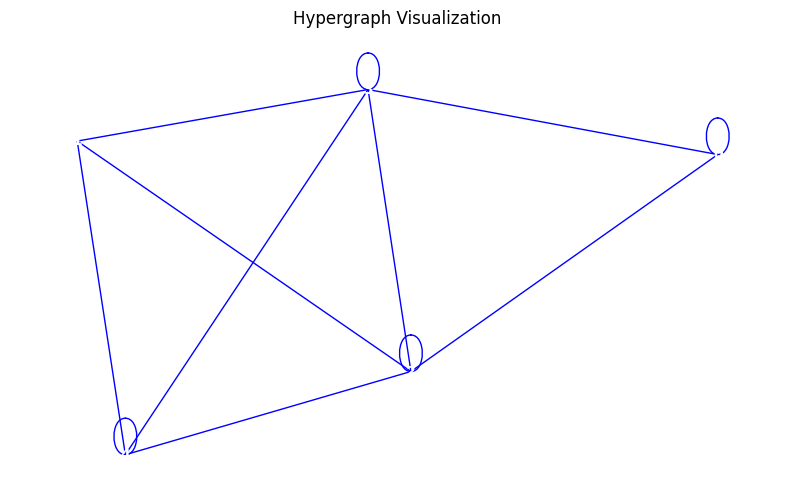

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def hypergraph_bipartite_config_2(deg_list, hyperedge_list):
    """
    input: generalized degree distribution P^A(k),
           which is a list of degrees for nodes.
           hyperedge order distribution P^B(k),
           which is a list of hyperedge orders.
    method: The two inputs are the two parts of a bipartite graph.
            Make k_i copies of labels for node n_i according to the degree list.
            Make o_i copies of labels for hyperedge e_i according to hyperedge order list.
            Randomly link and match the labels for nodes and the labels for hyperedges
            to create a hypergraph.
    output: a NetworkX hypergraph object.
    """

    # Create a list of node labels based on the degree distribution
    node_labels = []
    for idx, degree in enumerate(deg_list):
        node_labels.extend([idx] * degree)

    # Create a list of hyperedge labels based on the hyperedge order distribution
    hyperedge_labels = []
    for idx, order in enumerate(hyperedge_list):
        hyperedge_labels.extend([idx] * order)

    # Shuffle the node and hyperedge labels
    random.shuffle(node_labels)
    random.shuffle(hyperedge_labels)

    # Create the hypergraph
    hypergraph = nx.Graph()

    for node, hyperedge in zip(node_labels, hyperedge_labels):
        hypergraph.add_edge(node, hyperedge)

    return hypergraph


# Example usage
deg_list = [3,4,5,3,3]  # Example degree distribution for nodes
hyperedge_list = [3, 2, 5, 4, 4]  # Example hyperedge order distribution

hypergraph = hypergraph_bipartite_config(deg_list, hyperedge_list)

# Access hyperedge groups, number of items, and starting index
group_list = nx.get_node_attributes(hypergraph, "hyperedge")
count_list = [len(hypergraph[node]) for node in hypergraph.nodes]
index_list = [0] + list(np.cumsum(count_list))

# Plotting the hypergraph
pos = nx.spring_layout(hypergraph)
plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(hypergraph, pos, nodelist=group_list.keys(), node_color='r', node_size=200)
nx.draw_networkx_edges(hypergraph, pos, edgelist=hypergraph.edges, edge_color='b', width=1)
nx.draw_networkx_labels(hypergraph, pos, font_color='w', font_size=10, font_weight='bold')
plt.axis('off')
plt.title('Hypergraph Visualization')
plt.show()
